In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants as sc
import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


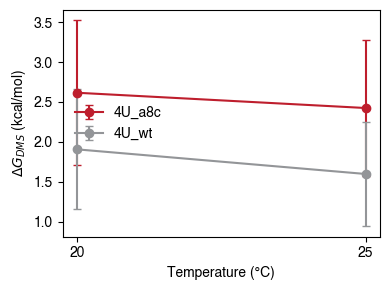

In [2]:
main_df_raw_20 = pd.read_csv('../07_2state_melt/4U_melt_fits.csv')
main_df_raw_25 = pd.read_csv('../07_2state_melt/4U_melt_fits_25C.csv')
agg_kadd = pd.read_csv('../07_2state_melt/fourU_agg_kaddfits.csv')

def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp, ignore_lnkadd_err = False):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    if ignore_lnkadd_err:
        lnKKp1_err = lnkobs_err

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / 4184) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err

agg_lookup = (
    agg_kadd[agg_kadd['index'] == 'aggregated']
    .set_index('base')[['slope', 'intercept', 'slope_se', 'intercept_se']]
)
agg_lookup = agg_lookup.astype(float)

def extrapolate_lnkadd(temp_c, base):
    if base not in agg_lookup.index:
        raise KeyError(f'No aggregated k_add fit available for base {base}')
    params = agg_lookup.loc[base]
    inv_temp = 1 / (temp_c + 273.15)
    lnkadd = params['slope'] * inv_temp + params['intercept']
    lnkadd_err = np.sqrt((inv_temp * params['slope_se'])**2 + params['intercept_se']**2)
    return lnkadd, lnkadd_err

lnkobs_sources = {
    20: main_df_raw_20,
    25: main_df_raw_25,
}

temp_records = []
for temp_c, df in lnkobs_sources.items():
    obs_col = f'lnkobs_{temp_c}C'
    err_col = f'{obs_col}_err'
    subset = df[['site', 'disp_name', obs_col, err_col, 'base']].copy()
    subset = subset.rename(columns={obs_col: 'lnkobs', err_col: 'lnkobs_err'})
    subset['lnkobs_err'] = subset['lnkobs_err'].fillna(0)
    subset['temp_C'] = temp_c

    lnkadd_vals = subset['base'].apply(lambda b: extrapolate_lnkadd(temp_c, b))
    subset['lnkadd'] = lnkadd_vals.apply(lambda v: v[0])
    subset['lnkadd_err'] = lnkadd_vals.apply(lambda v: v[1])

    dG_vals = subset.apply(lambda row: calc_dG(row['lnkobs'], row['lnkobs_err'], row['lnkadd'], row['lnkadd_err'], row['temp_C']), axis=1)
    subset['dG'] = dG_vals.apply(lambda v: v[0])
    subset['dG_err'] = dG_vals.apply(lambda v: v[1])

    subset['site_nt'] = subset['site'].astype(str) + subset['base']
    temp_records.append(subset)

dG_temp_df = pd.concat(temp_records, ignore_index=True)

main_df = (
    dG_temp_df[dG_temp_df['temp_C'] == 20]
    .rename(columns={
        'lnkobs': 'lnkobs_20C',
        'lnkobs_err': 'lnkobs_20C_err',
        'lnkadd': 'lnkadd_20C',
        'lnkadd_err': 'lnkadd_20C_err',
    })
    .drop(columns=['temp_C'])
)
main_df = main_df[['site', 'disp_name', 'lnkobs_20C', 'lnkobs_20C_err', 'lnkadd_20C', 'lnkadd_20C_err', 'base', 'site_nt', 'dG', 'dG_err']]

main_df.to_csv('fourU_calc_dG.csv', index=False)

summary = (
    dG_temp_df.groupby(['disp_name', 'temp_C'])
    .agg(dG_mean=('dG', 'mean'), dG_sd=('dG', 'std'))
    .reset_index()
)
summary['dG_sd'] = summary['dG_sd'].fillna(0)

palette = {'4U_wt': '#939598', '4U_a8c': '#BE1E2D'}

fig, ax = plt.subplots(figsize=(4, 3))
for label, grp in summary.groupby('disp_name'):
    ax.errorbar(
        grp['temp_C'],
        grp['dG_mean'],
        yerr=grp['dG_sd'],
        marker='o',
        linestyle='-',
        linewidth=1.5,
        color=palette.get(label, 'black'),
        label=label,
        capsize=3,
    )

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.set_xticks(sorted(dG_temp_df['temp_C'].unique()))
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('fourU_dG_vs_temp.pdf')
plt.show()



In [3]:
manual_18A = pd.read_csv('../07_2state_melt/manual_fourU_18.csv')
manual_18A['site_nt'] = manual_18A['site'].astype(str) + manual_18A['base'].astype(str)
manual_18A['dG'] = manual_18A.apply(lambda x: calc_dG(x['log_kobs'], 0, x['lnkadd_20C'], x['lnkadd_20C_err'], 20)[0], axis=1)
manual_18A['dG_err'] = manual_18A.apply(lambda x: calc_dG(x['log_kobs'], 0, x['lnkadd_20C'], x['lnkadd_20C_err'], 20)[1], axis=1)
# group by disp_name and get mean and std
manual_18A = manual_18A.groupby(['site', 'disp_name', 'base', 'site_nt']).agg({'dG': 'mean', 'dG_err': 'std'}).reset_index()
manual_18A['dG_err'] = manual_18A['dG_err'].fillna(0)

manual_combine = pd.concat([main_df[['site', 'disp_name', 'base', 'site_nt', 'dG', 'dG_err']],
           manual_18A[['site', 'disp_name', 'base', 'site_nt', 'dG', 'dG_err']]])
manual_combine.to_csv('4U_energy_with18A.csv')


In [4]:
# 25C

main_df = pd.read_csv('../07_2state_melt/4U_melt_fits_25C.csv')

def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp, ignore_lnkadd_err = False):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    if ignore_lnkadd_err:
        lnKKp1_err = lnkobs_err

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / 4184) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err, KKp1, KKp1_err

main_df['site_nt'] = main_df['site'].astype(str) + main_df['base'].astype(str)

# fill missing values with 0
main_df['lnkobs_25C_err'] = main_df['lnkobs_25C_err'].fillna(0)

main_df['dG'] = main_df.apply(lambda x: calc_dG(x['lnkobs_25C'], x['lnkobs_25C_err'], x['lnkadd_25C'], x['lnkadd_25C_err'], 25)[0], axis=1)
main_df['dG_err'] = main_df.apply(lambda x: calc_dG(x['lnkobs_25C'], x['lnkobs_25C_err'], x['lnkadd_25C'], x['lnkadd_25C_err'], 25)[1], axis=1)

manual_18A = pd.read_csv('../07_2state_melt/manual_fourU_18_25C.csv')
manual_18A['site_nt'] = manual_18A['site'].astype(str) + manual_18A['base'].astype(str)
manual_18A['dG'] = manual_18A.apply(lambda x: calc_dG(x['log_kobs'], 0, x['lnkadd_25C'], x['lnkadd_25C_err'], 25)[0], axis=1)
manual_18A['dG_err'] = manual_18A.apply(lambda x: calc_dG(x['log_kobs'], 0, x['lnkadd_25C'], x['lnkadd_25C_err'], 25)[1], axis=1)
# group by disp_name and get mean and std
manual_18A = manual_18A.groupby(['site', 'disp_name', 'base', 'site_nt']).agg({'dG': 'mean', 'dG_err': 'std'}).reset_index()
manual_18A['dG_err'] = manual_18A['dG_err'].fillna(0)

manual_combine = pd.concat([main_df[['site', 'disp_name', 'base', 'site_nt', 'dG', 'dG_err']],
           manual_18A[['site', 'disp_name', 'base', 'site_nt', 'dG', 'dG_err']]])
manual_combine.to_csv('4U_energy_with18A_25C.csv')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


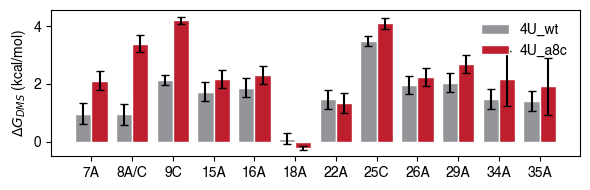

In [5]:
# Set color palette manually
palette = ['#939598', '#BE1E2D']
label_order = manual_combine['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(manual_combine['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(6, 2))

# Define bar width
bar_width = 0.4

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = manual_combine[manual_combine['disp_name'] == label]

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, df_subset['dG'], yerr=df_subset['dG_err'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=3)

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(['7A', '8A/C', '9C', '15A', '16A', '18A', '22A', '25C', '26A', '29A', '34A', '35A'])
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('fourU_calc_dG.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


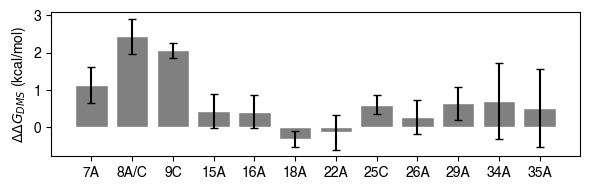

In [6]:
### Calculate ddG between 4U_wt and 4U_a8c

main_wt = manual_combine[manual_combine['disp_name'] == '4U_wt']
main_a8c = manual_combine[manual_combine['disp_name'] == '4U_a8c']

merged_df = pd.merge(main_wt, main_a8c, on='site', suffixes=('_wt', '_a8c'))[['site', 'site_nt_wt', 'dG_wt', 'dG_err_wt', 'dG_a8c', 'dG_err_a8c']]
merged_df['ddG'] = merged_df['dG_a8c'] - merged_df['dG_wt']
merged_df['ddG_err'] = np.sqrt(merged_df['dG_err_wt']**2 + merged_df['dG_err_a8c']**2)
merged_df = merged_df.sort_values(by='site')
merged_df.to_csv('fourU_calc_ddG.csv', index=False)

fig, ax = plt.subplots(figsize=(6, 2))

# X-axis positions
x = np.arange(len(merged_df))

# Bar plot with error bars
ax.bar(x, merged_df['ddG'], yerr=merged_df['ddG_err'], 
       color='gray', edgecolor='white', capsize=3)

# Update x-ticks to show site_nt_wt with 8A replaced
xtick_labels = merged_df['site_nt_wt'].replace(r'^8A$', '8A/C', regex=True)
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel('')
ax.set_ylabel(r'$\Delta\Delta G_{DMS}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('fourU_calc_ddG.pdf')

In [7]:
hiv_df = pd.read_csv('../07_2state_melt/hiv_25.csv')
temp = 25

hiv_df['site_nt'] = hiv_df['site'].astype(str) + hiv_df['base'].astype(str)
hiv_df['lnkobs_err'] = hiv_df['lnkobs_err'].fillna(0)
hiv_df['dG'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[0], axis=1)
hiv_df['dG_err'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[1], axis=1)

hiv_df.to_csv('hiv_calc_dG.csv', index=False)

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)


In [8]:
hiv_df = pd.read_csv('../07_2state_melt/hiv_kobs_kadd_vals_25.csv')
temp = 25

hiv_df['site_nt'] = hiv_df['site'].astype(str) + hiv_df['base'].astype(str)
hiv_df['lnkobs_err'] = hiv_df['lnkobs_err'].fillna(0)
hiv_df['dG'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[0], axis=1)
hiv_df['dG_err'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[1], axis=1)

hiv_df.to_csv('hiv_calc_dG.csv', index=False)

# filter out apical loop sites (30, 33, 35, 53)
apical_loop_sites = [24, 30, 33, 35, 53]
reporter_sites = [22, 24]
exclude_sites = [2, 3, 61, 62, 64]

hiv_apical_loop = hiv_df[hiv_df['site'].isin(apical_loop_sites)]
hiv_reporter = hiv_df[hiv_df['site'].isin(reporter_sites)]
hiv_main_stem = hiv_df[~hiv_df['site'].isin(apical_loop_sites)]
hiv_main_stem = hiv_main_stem[~hiv_main_stem['site'].isin(exclude_sites)]

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)


/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/2660123186.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/2660123186.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/v

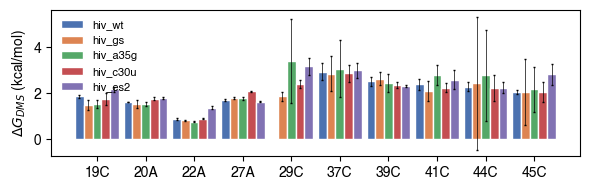

In [9]:
# Group by 'site' and compute mean dG and propagated error
def mean_with_error(group):
    dG_mean = group['dG'].mean()
    dG_err = np.sqrt((group['dG_err']**2).sum()) / len(group)
    return pd.Series({'dG_mean': dG_mean, 'dG_err_mean': dG_err})

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = hiv_main_stem['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_main_stem['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(6, 2))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = hiv_main_stem[hiv_main_stem['disp_name'] == label]

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'dG', 'dG_err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'dG': [np.nan], 'dG_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean dG
    meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()

    offset = (i - 2) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanDG_df['dG_mean'], yerr=meanDG_df['dG_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(['19C', '20A', '22A', '27A', '29C', '37C', '39C', '41C', '44C', '45C'])
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig('hiv_calc_dG.pdf')

In [10]:
hiv_df = pd.read_csv('../07_2state_melt/hiv_kobs_kadd_vals_25.csv')
temp = 25

hiv_df['site_nt'] = hiv_df['site'].astype(str) + hiv_df['base'].astype(str)
hiv_df['lnkobs_err'] = hiv_df['lnkobs_err'].fillna(0)
hiv_df['dG'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[0], axis=1)
hiv_df['dG_err'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[1], axis=1)
hiv_df['KKp1'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[2], axis=1)
hiv_df['KKp1_err'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[3], axis=1)

hiv_df.to_csv('hiv_calc_dG.csv', index=False)

# filter out apical loop sites (30, 33, 35, 53)
apical_loop_sites = [24, 30, 33, 34, 35, 53]
reporter_sites = [22, 24, 27]
exclude_sites = [2, 3, 61, 62, 64]

hiv_apical_loop = hiv_df[hiv_df['site'].isin(apical_loop_sites)]
hiv_reporter = hiv_df[hiv_df['site'].isin(reporter_sites)]
hiv_main_stem = hiv_df[~hiv_df['site'].isin(apical_loop_sites)]
hiv_main_stem = hiv_main_stem[~hiv_main_stem['site'].isin(exclude_sites)]
hiv_apical_loop

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)


,site,disp_name,lnkobs,lnkobs_err,lnkadd,lnkadd_err,base,site_nt,dG,dG_err,KKp1,KKp1_err
10,24,hiv_wt,-10.951469,0.020415,-10.958116,1.791457,C,24C,NaN,1.813776,1.006669,0.020551
11,24,hiv_wt,-11.108311,0.029788,-10.958116,1.791457,C,24C,-1.078196,0.126551,0.860540,0.025634
14,30,hiv_wt,-13.987561,0.258347,-10.958116,1.791457,C,30C,1.765543,0.160842,0.048342,0.012489
15,30,hiv_wt,-14.200455,0.187897,-10.958116,1.791457,C,30C,1.897423,0.115853,0.039072,0.007342
16,35,hiv_wt,-11.285248,0.026956,-10.127057,0.826593,A,35A,0.462870,0.023284,0.314054,0.008466
17,35,hiv_wt,-11.398142,0.040463,-10.127057,0.826593,A,35A,0.558031,0.033321,0.280527,0.011351
44,24,hiv_gs,-11.009497,0.017689,-10.958116,1.791457,C,24C,-1.743497,0.209257,0.949917,0.016803
45,24,hiv_gs,-11.076346,0.056617,-10.958116,1.791457,C,24C,-1.229659,0.300829,0.888492,0.050304
50,33,hiv_gs,-11.094048,0.024140,-10.958116,1.791457,C,33C,-1.141638,0.112531,0.872902,0.021072
51,33,hiv_gs,-11.182288,0.029287,-10.958116,1.791457,C,33C,-0.818318,0.086406,0.799178,0.023406


In [11]:
hiv_df = pd.read_csv('../07_2state_melt/hiv_kobs_kadd_vals_25.csv')
temp = 25

hiv_df['site_nt'] = hiv_df['site'].astype(str) + hiv_df['base'].astype(str)
hiv_df['lnkobs_err'] = hiv_df['lnkobs_err'].fillna(0)
hiv_df['dG'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[0], axis=1)
hiv_df['dG_err'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[1], axis=1)
hiv_df['KKp1'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[2], axis=1)
hiv_df['KKp1_err'] = hiv_df.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[3], axis=1)
hiv_df.to_csv('hiv_calc_dG.csv', index=False)

#hiv_df.to_csv('hiv_calc_dG.csv', index=False)

# filter out apical loop sites (30, 33, 35, 53)
apical_loop_sites = [24, 30, 33, 35, 53]
hiv_apical_loop = hiv_df[hiv_df['site'].isin(apical_loop_sites)]

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/822928874.py:19: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)


/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/1343828865.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/1343828865.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/v

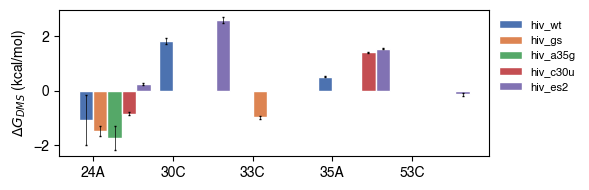

In [12]:

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = hiv_apical_loop['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_apical_loop['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(6, 2))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = hiv_apical_loop[hiv_apical_loop['disp_name'] == label]

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'dG', 'dG_err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'dG': [np.nan], 'dG_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean dG
    meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanDG_df['dG_mean'], yerr=meanDG_df['dG_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels([r'24A', '30C', '33C', '35A', '53C'])
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.savefig('hiv_apical_loop_calc_dG.pdf')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/868771947.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/868771947.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/var

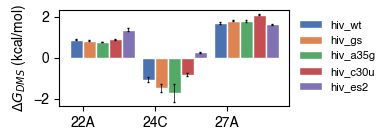

In [13]:

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = hiv_reporter['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_reporter['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(4, 1.5))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = hiv_reporter[hiv_reporter['disp_name'] == label].dropna()

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'dG', 'dG_err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'dG': [np.nan], 'dG_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean dG
    meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanDG_df['dG_mean'], yerr=meanDG_df['dG_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels([r'22A', '24C', '27A'])
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.savefig('hiv_reporter_calc_dG.pdf')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/46107928.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/46107928.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/var/f

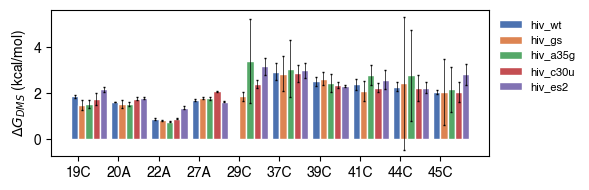

In [14]:

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = hiv_main_stem['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_main_stem['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(6, 2))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = hiv_main_stem[hiv_main_stem['disp_name'] == label]

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'dG', 'dG_err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'dG': [np.nan], 'dG_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean dG
    meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanDG_df['dG_mean'], yerr=meanDG_df['dG_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(['19C', '20A', '22A', '27A', '29C', '37C', '39C', '41C', '44C', '45C'])
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.savefig('hiv_main_stem_calc_dG.pdf')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/4086372502.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/4086372502.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/v

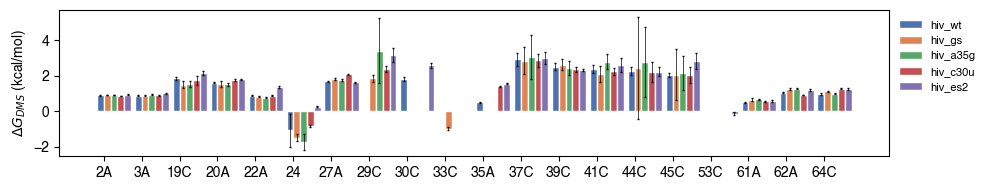

In [15]:

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = hiv_df['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_df['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(10, 2))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = hiv_df[hiv_df['disp_name'] == label]

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'dG', 'dG_err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'dG': [np.nan], 'dG_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean dG
    meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanDG_df['dG_mean'], yerr=meanDG_df['dG_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(['2A', '3A', '19C', '20A', '22A', '24', '27A', '29C', '30C', '33C', '35A', '37C', '39C', '41C', '44C', '45C', '53C', '61A', '62A', '64C'])
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.savefig('hiv_full_calc_dG.pdf')

In [16]:
df_subset.dropna()

,site,disp_name,lnkobs,lnkobs_err,lnkadd,lnkadd_err,base,site_nt,dG,dG_err,KKp1,KKp1_err
0,2,hiv_es2,-11.817343,0.096104,-10.127057,0.826593,A,2A,0.880654,0.069819,0.184467,0.017728
1,2,hiv_es2,-11.974854,0.052683,-10.127057,0.826593,A,2A,0.993192,0.037053,0.157584,0.008302
2,3,hiv_es2,-11.998952,0.034052,-10.127057,0.826593,A,3A,1.010103,0.023843,0.153832,0.005238
3,3,hiv_es2,-12.043425,0.045453,-10.127057,0.826593,A,3A,1.041119,0.031576,0.147140,0.006688
4,19,hiv_es2,-14.722873,0.138119,-10.958116,1.791457,C,19C,2.216670,0.083775,0.023173,0.003201
5,19,hiv_es2,-14.559526,0.288332,-10.958116,1.791457,C,19C,2.117391,0.175624,0.027285,0.007867
6,20,hiv_es2,-13.141846,0.097781,-10.127057,0.826593,A,20A,1.756415,0.060923,0.049056,0.004797
7,20,hiv_es2,-13.271557,0.086781,-10.127057,0.826593,A,20A,1.836973,0.053732,0.043088,0.003739
8,22,hiv_es2,-12.475245,0.046963,-10.127057,0.826593,A,22A,1.331769,0.030764,0.095542,0.004487
9,22,hiv_es2,-12.579810,0.185568,-10.127057,0.826593,A,22A,1.399904,0.120299,0.086056,0.015969


/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/201413722.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


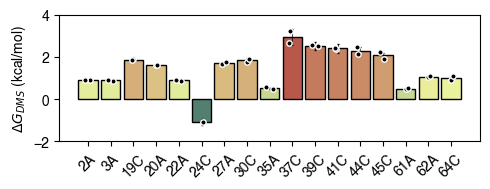

In [17]:
# --- new imports for colormap ---
from matplotlib import cm, colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

colors = ["#0f4c5c", "#ecf39e", "#9a031e"]
custom_cmap = LinearSegmentedColormap.from_list("black_blue_gold", colors)

# PLOT WT ONLY
hiv_wt = hiv_df[hiv_df['disp_name'] == 'hiv_wt']
label_order = hiv_wt['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_wt['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(5, 2))

# Define bar width
bar_width = 0.86

# Loop through each group (disp_name) – still works if you later have >1 group
for i, label in enumerate(label_order):
    df_subset = hiv_wt[hiv_wt['disp_name'] == label].copy()

    # Ensure all sites present
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    if missing_sites:
        df_subset = pd.concat([
            df_subset,
            pd.DataFrame({
                'site': list(missing_sites),
                'disp_name': label,
                'lnkobs': np.nan, 'lnkobs_err': np.nan,
                'lnkadd': np.nan, 'lnkadd_err': np.nan,
                'base': np.nan, 'site_nt': np.nan,
                'dG': np.nan, 'dG_err': np.nan
            })
        ], ignore_index=True)

    # Align to sorted x-axis positions and drop rows without values
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()
    df_subset = df_subset.dropna(subset=['dG'])  # keep rows with raw dG

    # --- 1) SCATTER RAW DATA (behind bars) ---
    # jitter each site's x for visibility
    jitter = (np.random.rand(len(df_subset)) - 0.5) * (bar_width * 0.35)
    x_for_points = df_subset['site'].map({s: xi for xi, s in enumerate(sorted_sites)}).values.astype(float)
    ax.scatter(
        x_for_points + jitter,
        df_subset['dG'].values,
        s=15, alpha=1, linewidths=1, edgecolors='white', facecolors='black', zorder=10
    )

    # Compute mean and error per site (expects mean_with_error to return dG_mean & dG_err_mean)
    meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)

    # Make sure order matches x
    meanDG_df = meanDG_df.set_index('site').loc[sorted_sites].reset_index()

    # --- 2) BAR COLOR BY VALUE USING custom cmap ---
    vals = meanDG_df['dG_mean'].values
    vmin, vmax = np.nanmin(vals), np.nanmax(vals)
    norm = mcolors.Normalize(vmin=-2, vmax=4)
    cmap = custom_cmap
    bar_colors = cmap(norm(vals))

    offset = (i) * bar_width
    ax.bar(
        x + offset,
        meanDG_df['dG_mean'],
        yerr=meanDG_df['dG_err_mean'],
        width=bar_width,
        color=bar_colors,
        edgecolor='black',
        capsize=1,
        error_kw={'linewidth': 0.5},
        zorder=2,
        label=label
    )

# Optional: add a colorbar to show the mapping (comment out if not desired)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)
#cbar.set_label(r'$\overline{\Delta G_{DMS}}$ (kcal/mol)', rotation=90, labelpad=8)

# Format plot
ax.set_ylim(-2, 4)
ax.set_xticks(x)
ax.set_xticklabels(['2A', '3A', '19C', '20A', '22A', '24C', '27A', '30C', '35A', '37C', '39C', '41C', '44C', '45C', '61A', '62A', '64C'], rotation=45)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend().remove()
plt.tight_layout()
plt.savefig('hiv_calc_dG_WTonly.pdf')

In [18]:
sorted_sites

[np.int64(2),
 np.int64(3),
 np.int64(19),
 np.int64(20),
 np.int64(22),
 np.int64(24),
 np.int64(27),
 np.int64(30),
 np.int64(35),
 np.int64(37),
 np.int64(39),
 np.int64(41),
 np.int64(44),
 np.int64(45),
 np.int64(61),
 np.int64(62),
 np.int64(64)]

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/816011261.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


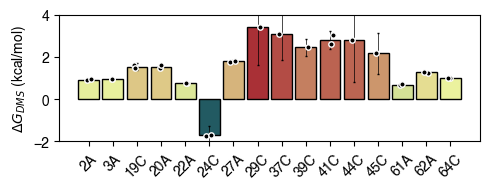

In [19]:
# --- new imports for colormap ---
from matplotlib import cm, colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

colors = ["#0f4c5c", "#ecf39e", "#9a031e"]
custom_cmap = LinearSegmentedColormap.from_list("black_blue_gold", colors)

# PLOT WT ONLY
hiv_wt = hiv_df[hiv_df['disp_name'] == 'hiv_a35g']
label_order = hiv_wt['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_wt['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(5, 2))

# Define bar width
bar_width = 0.86

# Loop through each group (disp_name) – still works if you later have >1 group
for i, label in enumerate(label_order):
    df_subset = hiv_wt[hiv_wt['disp_name'] == label].copy()

    # Ensure all sites present
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    if missing_sites:
        df_subset = pd.concat([
            df_subset,
            pd.DataFrame({
                'site': list(missing_sites),
                'disp_name': label,
                'lnkobs': np.nan, 'lnkobs_err': np.nan,
                'lnkadd': np.nan, 'lnkadd_err': np.nan,
                'base': np.nan, 'site_nt': np.nan,
                'dG': np.nan, 'dG_err': np.nan
            })
        ], ignore_index=True)

    # Align to sorted x-axis positions and drop rows without values
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()
    df_subset = df_subset.dropna(subset=['dG'])  # keep rows with raw dG

    # --- 1) SCATTER RAW DATA (behind bars) ---
    # jitter each site's x for visibility
    jitter = (np.random.rand(len(df_subset)) - 0.5) * (bar_width * 0.35)
    x_for_points = df_subset['site'].map({s: xi for xi, s in enumerate(sorted_sites)}).values.astype(float)
    ax.scatter(
        x_for_points + jitter,
        df_subset['dG'].values,
        s=15, alpha=1, linewidths=1, edgecolors='white', facecolors='black', zorder=10
    )

    # Compute mean and error per site (expects mean_with_error to return dG_mean & dG_err_mean)
    meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)

    # Make sure order matches x
    meanDG_df = meanDG_df.set_index('site').loc[sorted_sites].reset_index()

    # --- 2) BAR COLOR BY VALUE USING custom cmap ---
    vals = meanDG_df['dG_mean'].values
    vmin, vmax = np.nanmin(vals), np.nanmax(vals)
    norm = mcolors.Normalize(vmin=-2, vmax=4)
    cmap = custom_cmap
    bar_colors = cmap(norm(vals))

    offset = (i) * bar_width
    ax.bar(
        x + offset,
        meanDG_df['dG_mean'],
        yerr=meanDG_df['dG_err_mean'],
        width=bar_width,
        color=bar_colors,
        edgecolor='black',
        capsize=1,
        error_kw={'linewidth': 0.5},
        zorder=2,
        label=label
    )

# Optional: add a colorbar to show the mapping (comment out if not desired)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)
#cbar.set_label(r'$\overline{\Delta G_{DMS}}$ (kcal/mol)', rotation=90, labelpad=8)

# Format plot
ax.set_ylim(-2, 4)
ax.set_xticks(x)
ax.set_xticklabels(['2A', '3A', '19C', '20A', '22A', '24C', '27A', '29C', '37C', '39C', '41C', '44C', '45C', '61A', '62A', '64C'], rotation=45)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend().remove()
plt.tight_layout()
plt.savefig('hiv_calc_dG_a35g.pdf')

In [20]:
sorted_sites

[np.int64(2),
 np.int64(3),
 np.int64(19),
 np.int64(20),
 np.int64(22),
 np.int64(24),
 np.int64(27),
 np.int64(29),
 np.int64(37),
 np.int64(39),
 np.int64(41),
 np.int64(44),
 np.int64(45),
 np.int64(61),
 np.int64(62),
 np.int64(64)]

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/2402523326.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


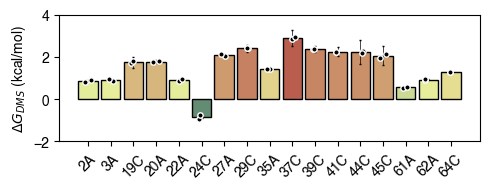

In [21]:
# --- new imports for colormap ---
from matplotlib import cm, colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

colors = ["#0f4c5c", "#ecf39e", "#9a031e"]
custom_cmap = LinearSegmentedColormap.from_list("black_blue_gold", colors)

# PLOT WT ONLY
hiv_wt = hiv_df[hiv_df['disp_name'] == 'hiv_c30u']
label_order = hiv_wt['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_wt['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(5, 2))

# Define bar width
bar_width = 0.86

# Loop through each group (disp_name) – still works if you later have >1 group
for i, label in enumerate(label_order):
    df_subset = hiv_wt[hiv_wt['disp_name'] == label].copy()

    # Ensure all sites present
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    if missing_sites:
        df_subset = pd.concat([
            df_subset,
            pd.DataFrame({
                'site': list(missing_sites),
                'disp_name': label,
                'lnkobs': np.nan, 'lnkobs_err': np.nan,
                'lnkadd': np.nan, 'lnkadd_err': np.nan,
                'base': np.nan, 'site_nt': np.nan,
                'dG': np.nan, 'dG_err': np.nan
            })
        ], ignore_index=True)

    # Align to sorted x-axis positions and drop rows without values
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()
    df_subset = df_subset.dropna(subset=['dG'])  # keep rows with raw dG

    # --- 1) SCATTER RAW DATA (behind bars) ---
    # jitter each site's x for visibility
    jitter = (np.random.rand(len(df_subset)) - 0.5) * (bar_width * 0.35)
    x_for_points = df_subset['site'].map({s: xi for xi, s in enumerate(sorted_sites)}).values.astype(float)
    ax.scatter(
        x_for_points + jitter,
        df_subset['dG'].values,
        s=15, alpha=1, linewidths=1, edgecolors='white', facecolors='black', zorder=10
    )

    # Compute mean and error per site (expects mean_with_error to return dG_mean & dG_err_mean)
    meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)

    # Make sure order matches x
    meanDG_df = meanDG_df.set_index('site').loc[sorted_sites].reset_index()

    # --- 2) BAR COLOR BY VALUE USING custom cmap ---
    vals = meanDG_df['dG_mean'].values
    vmin, vmax = np.nanmin(vals), np.nanmax(vals)
    norm = mcolors.Normalize(vmin=-2, vmax=4)
    cmap = custom_cmap
    bar_colors = cmap(norm(vals))

    offset = (i) * bar_width
    ax.bar(
        x + offset,
        meanDG_df['dG_mean'],
        yerr=meanDG_df['dG_err_mean'],
        width=bar_width,
        color=bar_colors,
        edgecolor='black',
        capsize=1,
        error_kw={'linewidth': 0.5},
        zorder=2,
        label=label
    )

# Optional: add a colorbar to show the mapping (comment out if not desired)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)
#cbar.set_label(r'$\overline{\Delta G_{DMS}}$ (kcal/mol)', rotation=90, labelpad=8)

# Format plot
ax.set_ylim(-2, 4)
ax.set_xticks(x)
ax.set_xticklabels(['2A', '3A', '19C', '20A', '22A', '24C', '27A', '29C', '35A', '37C', '39C', '41C', '44C', '45C', '61A', '62A', '64C'], rotation=45)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend().remove()
plt.tight_layout()
plt.savefig('hiv_calc_dG_c30u.pdf')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/3552430375.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


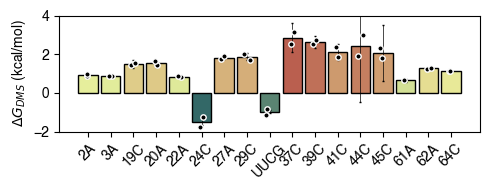

In [22]:
# --- new imports for colormap ---
from matplotlib import cm, colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

colors = ["#0f4c5c", "#ecf39e", "#9a031e"]
custom_cmap = LinearSegmentedColormap.from_list("black_blue_gold", colors)

# PLOT WT ONLY
hiv_wt = hiv_df[hiv_df['disp_name'] == 'hiv_gs']
label_order = hiv_wt['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_wt['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(5, 2))

# Define bar width
bar_width = 0.86

# Loop through each group (disp_name) – still works if you later have >1 group
for i, label in enumerate(label_order):
    df_subset = hiv_wt[hiv_wt['disp_name'] == label].copy()

    # Ensure all sites present
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    if missing_sites:
        df_subset = pd.concat([
            df_subset,
            pd.DataFrame({
                'site': list(missing_sites),
                'disp_name': label,
                'lnkobs': np.nan, 'lnkobs_err': np.nan,
                'lnkadd': np.nan, 'lnkadd_err': np.nan,
                'base': np.nan, 'site_nt': np.nan,
                'dG': np.nan, 'dG_err': np.nan
            })
        ], ignore_index=True)

    # Align to sorted x-axis positions and drop rows without values
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()
    df_subset = df_subset.dropna(subset=['dG'])  # keep rows with raw dG

    # --- 1) SCATTER RAW DATA (behind bars) ---
    # jitter each site's x for visibility
    jitter = (np.random.rand(len(df_subset)) - 0.5) * (bar_width * 0.35)
    x_for_points = df_subset['site'].map({s: xi for xi, s in enumerate(sorted_sites)}).values.astype(float)
    ax.scatter(
        x_for_points + jitter,
        df_subset['dG'].values,
        s=15, alpha=1, linewidths=1, edgecolors='white', facecolors='black', zorder=10
    )

    # Compute mean and error per site (expects mean_with_error to return dG_mean & dG_err_mean)
    meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)

    # Make sure order matches x
    meanDG_df = meanDG_df.set_index('site').loc[sorted_sites].reset_index()

    # --- 2) BAR COLOR BY VALUE USING custom cmap ---
    vals = meanDG_df['dG_mean'].values
    vmin, vmax = np.nanmin(vals), np.nanmax(vals)
    norm = mcolors.Normalize(vmin=-2, vmax=4)
    cmap = custom_cmap
    bar_colors = cmap(norm(vals))

    offset = (i) * bar_width
    ax.bar(
        x + offset,
        meanDG_df['dG_mean'],
        yerr=meanDG_df['dG_err_mean'],
        width=bar_width,
        color=bar_colors,
        edgecolor='black',
        capsize=1,
        error_kw={'linewidth': 0.5},
        zorder=2,
        label=label
    )

# Optional: add a colorbar to show the mapping (comment out if not desired)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)
#cbar.set_label(r'$\overline{\Delta G_{DMS}}$ (kcal/mol)', rotation=90, labelpad=8)

# Format plot
ax.set_ylim(-2, 4)
ax.set_xticks(x)
ax.set_xticklabels(['2A', '3A', '19C', '20A', '22A', '24C', '27A', '29C', 'UUCG', '37C', '39C', '41C', '44C', '45C', '61A', '62A', '64C'], rotation=45)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend().remove()
plt.tight_layout()
plt.savefig('hiv_calc_dG_uucg.pdf')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/3895402345.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


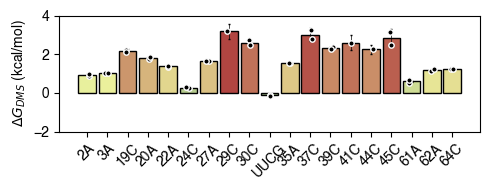

In [23]:
# --- new imports for colormap ---
from matplotlib import cm, colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

colors = ["#0f4c5c", "#ecf39e", "#9a031e"]
custom_cmap = LinearSegmentedColormap.from_list("black_blue_gold", colors)

# PLOT WT ONLY
hiv_wt = hiv_df[hiv_df['disp_name'] == 'hiv_es2']
label_order = hiv_wt['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = hiv_wt['site'].unique()
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(5, 2))

# Define bar width
bar_width = 0.86

# Loop through each group (disp_name) – still works if you later have >1 group
for i, label in enumerate(label_order):
    df_subset = hiv_wt[hiv_wt['disp_name'] == label].copy()

    # Ensure all sites present
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    if missing_sites:
        df_subset = pd.concat([
            df_subset,
            pd.DataFrame({
                'site': list(missing_sites),
                'disp_name': label,
                'lnkobs': np.nan, 'lnkobs_err': np.nan,
                'lnkadd': np.nan, 'lnkadd_err': np.nan,
                'base': np.nan, 'site_nt': np.nan,
                'dG': np.nan, 'dG_err': np.nan
            })
        ], ignore_index=True)

    # Align to sorted x-axis positions and drop rows without values
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()
    df_subset = df_subset.dropna(subset=['dG'])  # keep rows with raw dG

    # --- 1) SCATTER RAW DATA (behind bars) ---
    # jitter each site's x for visibility
    jitter = (np.random.rand(len(df_subset)) - 0.5) * (bar_width * 0.35)
    x_for_points = df_subset['site'].map({s: xi for xi, s in enumerate(sorted_sites)}).values.astype(float)
    ax.scatter(
        x_for_points + jitter,
        df_subset['dG'].values,
        s=15, alpha=1, linewidths=1, edgecolors='white', facecolors='black', zorder=10
    )

    # Compute mean and error per site (expects mean_with_error to return dG_mean & dG_err_mean)
    meanDG_df = df_subset.groupby('site', as_index=False).apply(mean_with_error).reset_index(drop=True)

    # Make sure order matches x
    meanDG_df = meanDG_df.set_index('site').loc[sorted_sites].reset_index()

    # --- 2) BAR COLOR BY VALUE USING MAGMA ---
    vals = meanDG_df['dG_mean'].values
    vmin, vmax = np.nanmin(vals), np.nanmax(vals)
    norm = mcolors.Normalize(vmin=-2, vmax=4)
    cmap = custom_cmap
    bar_colors = cmap(norm(vals))

    offset = (i) * bar_width
    ax.bar(
        x + offset,
        meanDG_df['dG_mean'],
        yerr=meanDG_df['dG_err_mean'],
        width=bar_width,
        color=bar_colors,
        edgecolor='black',
        capsize=1,
        error_kw={'linewidth': 0.5},
        zorder=2,
        label=label
    )

# Optional: add a colorbar to show the mapping (comment out if not desired)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)
#cbar.set_label(r'$\overline{\Delta G_{DMS}}$ (kcal/mol)', rotation=90, labelpad=8)
# Format plot
ax.set_ylim(-2, 4)
ax.set_xticks(x)
ax.set_xticklabels(['2A', '3A', '19C', '20A', '22A', '24C', '27A', '29C','30C', 'UUCG', '35A', '37C', '39C', '41C', '44C', '45C', '61A', '62A', '64C'], rotation=45)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend().remove()
plt.tight_layout()
plt.savefig('hiv_calc_dG_ES2only.pdf')

In [24]:
sorted_sites

array([ 2,  3, 19, 20, 22, 24, 27, 29, 30, 53, 35, 37, 39, 41, 44, 45, 61,
       62, 64])

array([ 2,  3, 19, 20, 22, 24, 27, 30, 35, 37, 39, 41, 44, 45, 61, 62, 64,
       29, 33, 53])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


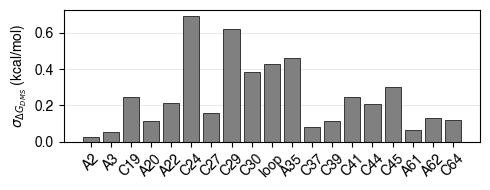

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# mean group by disp_name
dG_grouped = hiv_df.groupby(["site", "disp_name"])["dG"].mean().reset_index()

# replace site 53 with 33
dG_grouped["site"] = dG_grouped["site"].replace({53: 33})

sites = sorted(dG_grouped["site"].dropna().unique())

dG_std = []
for site in sites:
    dG_values = dG_grouped[dG_grouped["site"] == site]["dG"].values
    dG_std.append(np.nanstd(dG_values))

# barplot: site vs dG std
fig, ax = plt.subplots(figsize=(5, 2))

x = np.arange(len(dG_grouped["site"].unique()))
ax.bar(
    x,
    dG_std,
    width=0.8,
    edgecolor="black",
    color = 'gray',
    linewidth=0.5,
    zorder=2,
)

ax.set_xticks(x)
#ax.set_xticklabels([str(s) for s in sites], rotation=90, fontsize=7)
ax.set_xlabel("")
ax.set_xticklabels(['A2', 'A3', 'C19', 'A20', 'A22', 'C24', 'C27', 'C29','C30', 'loop', 'A35', 'C37', 'C39', 'C41', 'C44', 'C45', 'A61', 'A62', 'C64'], rotation=45)
ax.set_ylabel(r"$\sigma_{\Delta G_{DMS}}$ (kcal/mol)")
ax.grid(axis="y", linewidth=0.5, alpha=0.4, zorder=0)

plt.tight_layout()
plt.savefig("hiv_dG_stddev_barplot.pdf")
plt.show()

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/1920026378.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanKKp1_df = df_subset.groupby('site').apply(KKp1_mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/1920026378.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanKKp1_df = df_subset.groupby('site').apply(KKp1_mean_with_error).re

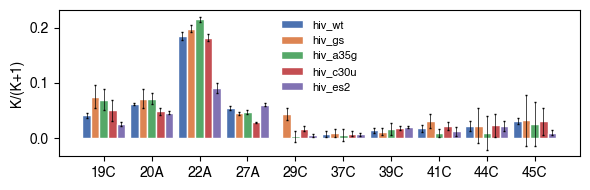

In [25]:
#hiv_main_stem = hiv_main_stem[~hiv_main_stem['site'].isin(exclude_sites)]
#hiv_apical_loop

# Group by 'site' and compute mean dG and propagated error
def KKp1_mean_with_error(group):
    KKp1_mean = group['KKp1'].mean()
    KKp1_err = np.sqrt((group['KKp1_err']**2).sum()) / len(group)
    return pd.Series({'KKp1_mean': KKp1_mean, 'KKp1_err_mean': KKp1_err})

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = hiv_main_stem['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_main_stem['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(6, 2))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = hiv_main_stem[hiv_main_stem['disp_name'] == label]

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'KKp1', 'KKp1 _err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'KKp1': [np.nan], 'KKp1_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean KKp1
    meanKKp1_df = df_subset.groupby('site').apply(KKp1_mean_with_error).reset_index()

    offset = (i - 2) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanKKp1_df['KKp1_mean'], yerr=meanKKp1_df['KKp1_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(['19C', '20A', '22A', '27A', '29C', '37C', '39C', '41C', '44C', '45C'])
ax.set_xlabel('')
ax.set_ylabel(r'K/(K+1)')
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig('hiv_calc_KKp1.pdf')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/2194472933.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(KKp1_mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/2194472933.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(KKp1_mean_with_error).reset_

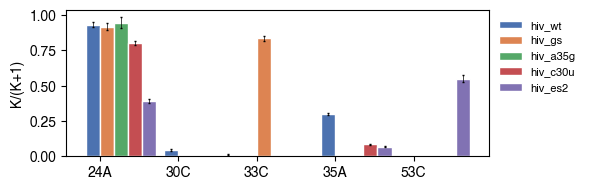

In [26]:

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = hiv_apical_loop['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_apical_loop['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(6, 2))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = hiv_apical_loop[hiv_apical_loop['disp_name'] == label]

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'dG', 'dG_err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'dG': [np.nan], 'dG_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean dG
    meanDG_df = df_subset.groupby('site').apply(KKp1_mean_with_error).reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanDG_df['KKp1_mean'], yerr=meanDG_df['KKp1_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels([r'24A', '30C', '33C', '35A', '53C'])
ax.set_xlabel('')
ax.set_ylabel(r'K/(K+1)')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.savefig('hiv_apical_loop_calc_KKp1.pdf')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/3442181893.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanKKp1_df = df_subset.groupby('site').apply(KKp1_mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/3442181893.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanKKp1_df = df_subset.groupby('site').apply(KKp1_mean_with_error).re

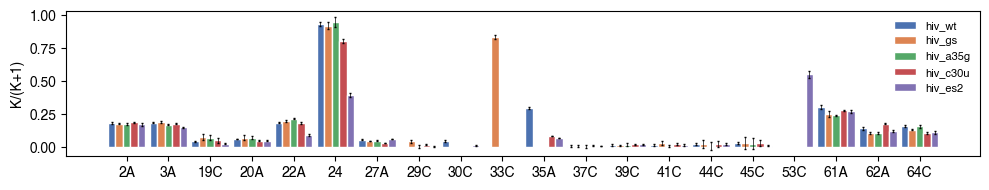

In [27]:
#hiv_df = hiv_df[~hiv_df['site'].isin(exclude_sites)]
#hiv_apical_loop

# Group by 'site' and compute mean dG and propagated error
def KKp1_mean_with_error(group):
    KKp1_mean = group['KKp1'].mean()
    KKp1_err = np.sqrt((group['KKp1_err']**2).sum()) / len(group)
    return pd.Series({'KKp1_mean': KKp1_mean, 'KKp1_err_mean': KKp1_err})

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = hiv_df['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(hiv_df['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(10, 2))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = hiv_df[hiv_df['disp_name'] == label]

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'KKp1', 'KKp1 _err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'KKp1': [np.nan], 'KKp1_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean KKp1
    meanKKp1_df = df_subset.groupby('site').apply(KKp1_mean_with_error).reset_index()

    offset = (i - 2) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanKKp1_df['KKp1_mean'], yerr=meanKKp1_df['KKp1_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(['2A', '3A', '19C', '20A', '22A', '24', '27A', '29C', '30C', '33C', '35A', '37C', '39C', '41C', '44C', '45C', '53C', '61A', '62A', '64C'])
ax.set_xlabel('')
ax.set_ylabel(r'K/(K+1)')
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig('hiv_calc_KKp1_full.pdf')

In [28]:
#### BARPLOT FOR P4P6

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


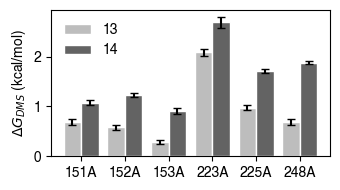

In [29]:
sites = sorted([151, 152, 153, 223, 225, 248])
site_labels = ['151A', '152A', '153A', '223A', '225A', '248A']

p4p6_df = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/11_dG_scale_classification/reference/23_modrate_MRT_fit_with_error.csv')[['site', 'site_nt', 'buffer', 'base', 'dG', 'dG_err']]
p4p6_site_df = p4p6_df[p4p6_df['site'].isin(sites)]

# Set color palette manually
palette = ['#bdbdbd', '#636363']
label_order = [13, 14]

# Sort sites numerically and define x positions
sorted_sites = sorted(p4p6_site_df['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(3.5, 2))

# Define bar width
bar_width = 0.4

# Loop through each group (buffer)
for i, label in enumerate(label_order):
    df_subset = p4p6_site_df[p4p6_site_df['buffer'] == label]

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, df_subset['dG'], yerr=df_subset['dG_err'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=3)

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(site_labels)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('p4p6_TL-TLR_calc_dG.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


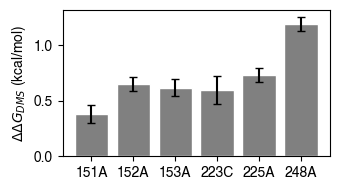

In [30]:
main_mg = p4p6_site_df[p4p6_site_df['buffer'] == 14]
main_nomg = p4p6_site_df[p4p6_site_df['buffer'] == 13]

merged_df = pd.merge(main_mg, main_nomg, on='site', suffixes=('_mg', '_nomg'))[['site', 'site_nt_mg', 'dG_mg', 'dG_err_mg', 'dG_nomg', 'dG_err_nomg']]
merged_df['ddG'] = merged_df['dG_mg'] - merged_df['dG_nomg']
merged_df['ddG_err'] = np.sqrt(merged_df['dG_err_mg']**2 + merged_df['dG_err_nomg']**2)
merged_df = merged_df.sort_values(by='site')
#merged_df.to_csv('fourU_calc_ddG.csv', index=False)

fig, ax = plt.subplots(figsize=(3.5, 2))

# X-axis positions
x = np.arange(len(merged_df))

# Bar plot with error bars
ax.bar(x, merged_df['ddG'], yerr=merged_df['ddG_err'], 
       color='gray', edgecolor='white', capsize=3)

# Update x-ticks to show site_nt_mg with 8A replaced
xtick_labels = merged_df['site_nt_mg']#.str.replace('8A', '8A/C')
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel('')
ax.set_ylabel(r'$\Delta\Delta G_{DMS}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('p4p6_TL-TLR_calc_ddG.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


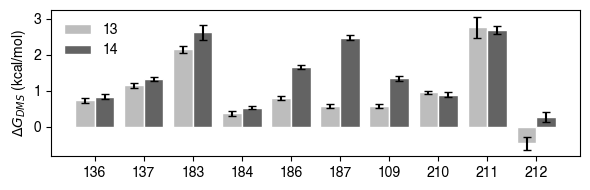

In [31]:
sites = [136, 137, 183, 184, 186, 187, 109, 210, 211, 212]
p4p6_df = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/11_dG_scale_classification/reference/23_modrate_MRT_fit_with_error.csv')[['site', 'site_nt', 'buffer', 'base', 'dG', 'dG_err']]
p4p6_site_df = p4p6_df[p4p6_df['site'].isin(sites)]

# Set color palette manually
palette = ['#bdbdbd', '#636363']
label_order = [13, 14]

# Sort sites numerically and define x positions
sorted_sites = sorted(p4p6_site_df['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(6, 2))

# Define bar width
bar_width = 0.4

# Loop through each group (buffer)
for i, label in enumerate(label_order):
    df_subset = p4p6_site_df[p4p6_site_df['buffer'] == label]

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, df_subset['dG'], yerr=df_subset['dG_err'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=3)

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(sites)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('p4p6_MC-MCR_calc_dG.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


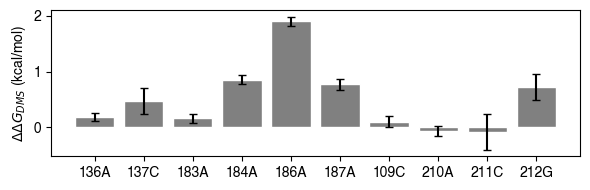

In [32]:
main_mg = p4p6_site_df[p4p6_site_df['buffer'] == 14]
main_nomg = p4p6_site_df[p4p6_site_df['buffer'] == 13]

merged_df = pd.merge(main_mg, main_nomg, on='site', suffixes=('_mg', '_nomg'))[['site', 'site_nt_mg', 'dG_mg', 'dG_err_mg', 'dG_nomg', 'dG_err_nomg']]
merged_df['ddG'] = merged_df['dG_mg'] - merged_df['dG_nomg']
merged_df['ddG_err'] = np.sqrt(merged_df['dG_err_mg']**2 + merged_df['dG_err_nomg']**2)
merged_df = merged_df.sort_values(by='site')
#merged_df.to_csv('fourU_calc_ddG.csv', index=False)

# re-order based on sites = [136, 137, 183, 184, 186, 187, 109, 210, 211, 212]
merged_df = merged_df.set_index('site').loc[sites].reset_index()

fig, ax = plt.subplots(figsize=(6, 2))

# X-axis positions
x = np.arange(len(merged_df))

# Bar plot with error bars
ax.bar(x, merged_df['ddG'], yerr=merged_df['ddG_err'], 
       color='gray', edgecolor='white', capsize=3)

# Update x-ticks to show site_nt_mg with 8A replaced
xtick_labels = merged_df['site_nt_mg']#.str.replace('8A', '8A/C')
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel('')
ax.set_ylabel(r'$\Delta\Delta G_{DMS}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('p4p6_MC-MCR_calc_ddG.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


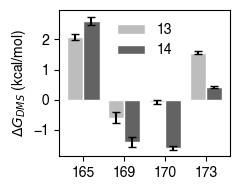

In [33]:
sites = sorted([165, 169, 170, 173])
p4p6_df = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/11_dG_scale_classification/reference/23_modrate_MRT_fit_with_error.csv')[['site', 'site_nt', 'buffer', 'base', 'dG', 'dG_err']]
p4p6_site_df = p4p6_df[p4p6_df['site'].isin(sites)]

# Set color palette manually
palette = ['#bdbdbd', '#636363']
label_order = [13, 14]

# Sort sites numerically and define x positions
sorted_sites = sorted(p4p6_site_df['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(2.5, 2))

# Define bar width
bar_width = 0.4

# Loop through each group (buffer)
for i, label in enumerate(label_order):
    df_subset = p4p6_site_df[p4p6_site_df['buffer'] == label]

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, df_subset['dG'], yerr=df_subset['dG_err'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=3)

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(sites)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('p4p6_altP5c_calc_dG.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


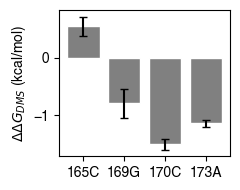

In [34]:
main_mg = p4p6_site_df[p4p6_site_df['buffer'] == 14]
main_nomg = p4p6_site_df[p4p6_site_df['buffer'] == 13]

merged_df = pd.merge(main_mg, main_nomg, on='site', suffixes=('_mg', '_nomg'))[['site', 'site_nt_mg', 'dG_mg', 'dG_err_mg', 'dG_nomg', 'dG_err_nomg']]
merged_df['ddG'] = merged_df['dG_mg'] - merged_df['dG_nomg']
merged_df['ddG_err'] = np.sqrt(merged_df['dG_err_mg']**2 + merged_df['dG_err_nomg']**2)
merged_df = merged_df.sort_values(by='site')
#merged_df.to_csv('fourU_calc_ddG.csv', index=False)

fig, ax = plt.subplots(figsize=(2.5, 2))

# X-axis positions
x = np.arange(len(merged_df))

# Bar plot with error bars
ax.bar(x, merged_df['ddG'], yerr=merged_df['ddG_err'], 
       color='gray', edgecolor='white', capsize=3)

# Update x-ticks to show site_nt_mg with 8A replaced
xtick_labels = merged_df['site_nt_mg']#.str.replace('8A', '8A/C')
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel('')
ax.set_ylabel(r'$\Delta\Delta G_{DMS}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('p4p6_altP5c_calc_ddG.pdf')

/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/matplotlib/transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/matplotlib/transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


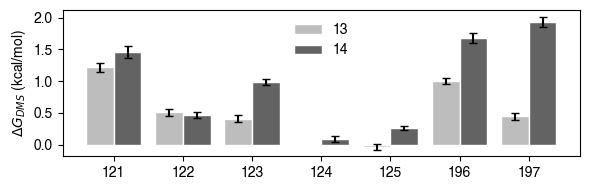

In [35]:
sites = sorted([121, 122, 123, 124, 125, 196, 197])
p4p6_df = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/11_dG_scale_classification/reference/23_modrate_MRT_fit_with_error.csv')[['site', 'site_nt', 'buffer', 'base', 'dG', 'dG_err']]
p4p6_site_df = p4p6_df[p4p6_df['site'].isin(sites)]

# Set color palette manually
palette = ['#bdbdbd', '#636363']
label_order = [13, 14]

# Sort sites numerically and define x positions
sorted_sites = sorted(p4p6_site_df['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(6, 2))

# Define bar width
bar_width = 0.4

# Loop through each group (buffer)
for i, label in enumerate(label_order):
    df_subset = p4p6_site_df[p4p6_site_df['buffer'] == label]

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, df_subset['dG'], yerr=df_subset['dG_err'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=3)

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(sites)
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('p4p6_j55a_calc_dG.pdf')

/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/matplotlib/transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/matplotlib/transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


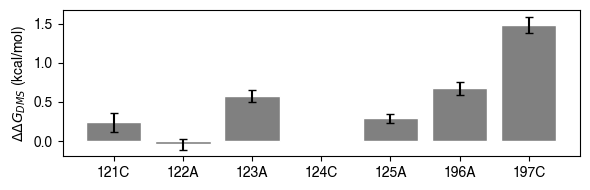

In [36]:
main_mg = p4p6_site_df[p4p6_site_df['buffer'] == 14]
main_nomg = p4p6_site_df[p4p6_site_df['buffer'] == 13]

merged_df = pd.merge(main_mg, main_nomg, on='site', suffixes=('_mg', '_nomg'))[['site', 'site_nt_mg', 'dG_mg', 'dG_err_mg', 'dG_nomg', 'dG_err_nomg']]
merged_df['ddG'] = merged_df['dG_mg'] - merged_df['dG_nomg']
merged_df['ddG_err'] = np.sqrt(merged_df['dG_err_mg']**2 + merged_df['dG_err_nomg']**2)
merged_df = merged_df.sort_values(by='site')
#merged_df.to_csv('fourU_calc_ddG.csv', index=False)

fig, ax = plt.subplots(figsize=(6, 2))

# X-axis positions
x = np.arange(len(merged_df))

# Bar plot with error bars
ax.bar(x, merged_df['ddG'], yerr=merged_df['ddG_err'], 
       color='gray', edgecolor='white', capsize=3)

# Update x-ticks to show site_nt_mg with 8A replaced
xtick_labels = merged_df['site_nt_mg']#.str.replace('8A', '8A/C')
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel('')
ax.set_ylabel(r'$\Delta\Delta G_{DMS}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('p4p6_j55a_calc_ddG.pdf')

In [37]:
from scipy.stats import t

n = 6  # number of replicates

def compute_welch_ttest(row):
    mean1 = row['dG_mg']
    mean2 = row['dG_nomg']
    se1 = row['dG_err_mg']
    se2 = row['dG_err_nomg']

    # Calculate t-statistic
    t_stat = (mean1 - mean2) / np.sqrt(se1**2 + se2**2)

    # Degrees of freedom using Welch–Satterthwaite equation
    df_num = (se1**2 + se2**2)**2
    df_denom = (se1**4) / (n - 1) + (se2**4) / (n - 1)
    df = df_num / df_denom

    # Two-tailed p-value
    p_val = 2 * t.sf(np.abs(t_stat), df)

    return pd.Series({'t_stat': t_stat, 'df': df, 'p_val': p_val})

In [38]:
p4p6_df_nomg = p4p6_df[p4p6_df['buffer'] == 13]
p4p6_df_mg = p4p6_df[p4p6_df['buffer'] == 14]
merged_df = pd.merge(p4p6_df_mg, p4p6_df_nomg, on='site', suffixes=('_mg', '_nomg'))[['site', 'site_nt_mg', 'dG_mg', 'dG_err_mg', 'dG_nomg', 'dG_err_nomg']]

# Calculate ddG and its propagated error
merged_df['ddG'] = merged_df['dG_mg'] - merged_df['dG_nomg']
merged_df['ddG_err'] = np.sqrt(merged_df['dG_err_mg']**2 + merged_df['dG_err_nomg']**2)

merged_df[['t_stat', 'df', 'p_val']] = merged_df.apply(compute_welch_ttest, axis=1)
merged_df[merged_df['p_val'] < 0.05]

,site,site_nt_mg,dG_mg,dG_err_mg,dG_nomg,dG_err_nomg,ddG,ddG_err,t_stat,df,p_val
3,106,106T,-0.756664,0.192054,0.555779,0.173511,-1.312443,0.258826,-5.070757,9.898657,4.998472e-04
6,113,113A,1.049238,0.036333,0.776076,0.057158,0.273162,0.067729,4.033169,8.473527,3.349082e-03
11,123,123A,0.986655,0.048366,0.411044,0.056170,0.575610,0.074124,7.765521,9.784294,1.734194e-05
12,124,124C,0.089224,0.052584,-inf,0.048426,inf,0.071485,inf,9.932926,0.000000e+00
13,125,125A,0.260996,0.034506,-0.030481,0.048053,0.291478,0.059159,4.927055,9.073446,7.973321e-04
14,128,128C,2.794668,0.197150,2.189366,0.057675,0.605302,0.205413,2.946761,5.849594,2.650515e-02
15,130,130T,-0.852069,0.131312,0.251679,0.255655,-1.103749,0.287406,-3.840385,7.466489,5.635057e-03
16,132,132C,1.947601,0.073824,1.489167,0.066457,0.458434,0.099330,4.615250,9.891471,9.853260e-04
17,133,133A,1.669444,0.038761,1.335962,0.035377,0.333483,0.052478,6.354738,9.917705,8.612198e-05
18,134,134G,0.349037,0.203898,-0.915023,0.145819,1.264060,0.250674,5.042649,9.054025,6.846142e-04


<Axes: >

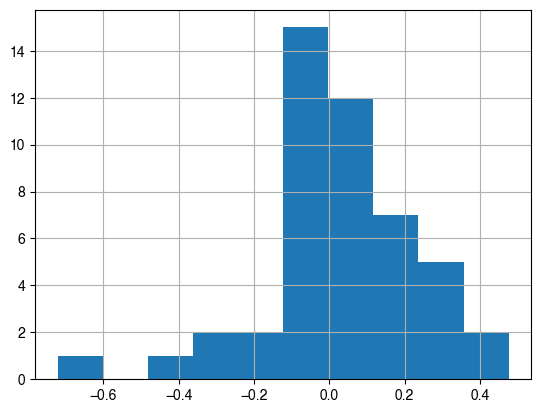

In [39]:
merged_df[(merged_df['p_val'] >= 0.05) & np.isfinite(merged_df['ddG'])]['ddG'].hist()

<Axes: >

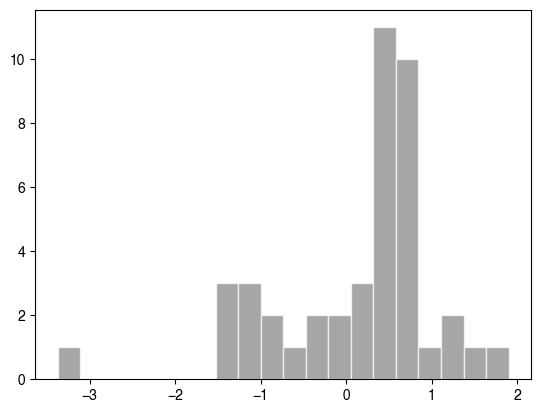

In [40]:
merged_df[(merged_df['p_val'] < 0.05) & np.isfinite(merged_df['ddG'])]['ddG'].hist(bins = 20, edgecolor='white', grid=False, alpha=0.7, color='gray')

In [41]:
wcf_sites = [252, 246, 229, 230, 231, 232, 233, 234, 130, 132, 133, 193, 161, 159, 146, 154]

filtered_ddG_wcf = merged_df[(merged_df['p_val'] < 0.05) & np.isfinite(merged_df['ddG']) & merged_df['site'].isin(wcf_sites)]

filtered_ddG_wcf['filter'] = 'WCF'

# Filter the data
filtered_ddG = merged_df[(merged_df['p_val'] < 0.05) & np.isfinite(merged_df['ddG']) & ~merged_df['site'].isin(wcf_sites)]
filtered_ddG['filter'] = 'Non-WCF'

filtered_ddG


/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/3836849771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ddG_wcf['filter'] = 'WCF'
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_97460/3836849771.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ddG['filter'] = 'Non-WCF'


,site,site_nt_mg,dG_mg,dG_err_mg,dG_nomg,dG_err_nomg,ddG,ddG_err,t_stat,df,p_val,filter
3,106,106T,-0.756664,0.192054,0.555779,0.173511,-1.312443,0.258826,-5.070757,9.898657,4.998472e-04,Non-WCF
6,113,113A,1.049238,0.036333,0.776076,0.057158,0.273162,0.067729,4.033169,8.473527,3.349082e-03,Non-WCF
11,123,123A,0.986655,0.048366,0.411044,0.056170,0.575610,0.074124,7.765521,9.784294,1.734194e-05,Non-WCF
13,125,125A,0.260996,0.034506,-0.030481,0.048053,0.291478,0.059159,4.927055,9.073446,7.973321e-04,Non-WCF
14,128,128C,2.794668,0.197150,2.189366,0.057675,0.605302,0.205413,2.946761,5.849594,2.650515e-02,Non-WCF
18,134,134G,0.349037,0.203898,-0.915023,0.145819,1.264060,0.250674,5.042649,9.054025,6.846142e-04,Non-WCF
20,136,136A,1.327057,0.048828,1.144985,0.058855,0.182072,0.076473,2.380861,9.670347,3.935368e-02,Non-WCF
22,138,138C,2.529959,0.058467,2.088442,0.072123,0.441517,0.092844,4.755445,9.589529,8.691667e-04,Non-WCF
23,139,139A,-0.348676,0.035120,0.086412,0.045215,-0.435088,0.057252,-7.599498,9.423224,2.576730e-05,Non-WCF
27,151,151A,1.072319,0.052411,0.694236,0.063310,0.378084,0.082189,4.600149,9.663131,1.071544e-03,Non-WCF


In [42]:
filtered_ddG_wcf_all = pd.concat([filtered_ddG[['site', 'ddG', 'p_val', 'filter']], filtered_ddG_wcf[['site', 'ddG', 'p_val', 'filter']]], ignore_index=True)
filtered_ddG_wcf_all['filter'].value_counts()

filter
Non-WCF    37
WCF         6
Name: count, dtype: int64

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


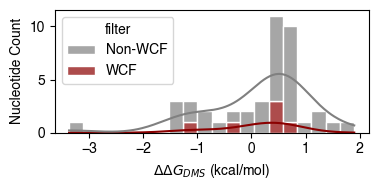

In [43]:
# Create the plot
plt.figure(figsize=(4, 2))
palette = sns.color_palette(['gray', 'darkred'])
sns.histplot(data=filtered_ddG_wcf_all, x='ddG', bins=20, hue='filter', kde=True, color='gray', edgecolor='white', alpha=0.7, multiple='stack', stat='count', palette=palette)
plt.xlabel(r'$\Delta\Delta G_{DMS}$ (kcal/mol)')
plt.ylabel('Nucleotide Count')
plt.tight_layout()
plt.savefig('p4p6_ddG_histogram.pdf')
plt.show()

In [44]:
# Compute histogram bins
counts, bin_edges = np.histogram(filtered_ddG, bins=20)

# Display bin edges
print("Bin edges:", bin_edges)

TypeError: '<=' not supported between instances of 'int' and 'str'

In [ ]:
filtered_ddG = merged_df[(merged_df['p_val'] < 0.05) & np.isfinite(merged_df['ddG'])]
filtered_ddG

,site,site_nt_mg,dG_mg,dG_err_mg,dG_nomg,dG_err_nomg,ddG,ddG_err,t_stat,df,p_val
3,106,106T,-0.756664,0.192054,0.555779,0.173511,-1.312443,0.258826,-5.070757,9.898657,4.998472e-04
6,113,113A,1.049238,0.036333,0.776076,0.057158,0.273162,0.067729,4.033169,8.473527,3.349082e-03
11,123,123A,0.986655,0.048366,0.411044,0.056170,0.575610,0.074124,7.765521,9.784294,1.734194e-05
13,125,125A,0.260996,0.034506,-0.030481,0.048053,0.291478,0.059159,4.927055,9.073446,7.973321e-04
14,128,128C,2.794668,0.197150,2.189366,0.057675,0.605302,0.205413,2.946761,5.849594,2.650515e-02
15,130,130T,-0.852069,0.131312,0.251679,0.255655,-1.103749,0.287406,-3.840385,7.466489,5.635057e-03
16,132,132C,1.947601,0.073824,1.489167,0.066457,0.458434,0.099330,4.615250,9.891471,9.853260e-04
17,133,133A,1.669444,0.038761,1.335962,0.035377,0.333483,0.052478,6.354738,9.917705,8.612198e-05
18,134,134G,0.349037,0.203898,-0.915023,0.145819,1.264060,0.250674,5.042649,9.054025,6.846142e-04
20,136,136A,1.327057,0.048828,1.144985,0.058855,0.182072,0.076473,2.380861,9.670347,3.935368e-02


In [ ]:
## filtered_ddG get rows between 0.31796013  and  0.84528138

filtered_ddG = merged_df[(merged_df['p_val'] < 0.05) & np.isfinite(merged_df['ddG'])]
filtered_ddG = filtered_ddG[(filtered_ddG['ddG'] >= 0.31796013) & (filtered_ddG['ddG'] <= 0.84528138)]
filtered_ddG

,site,site_nt_mg,dG_mg,dG_err_mg,dG_nomg,dG_err_nomg,ddG,ddG_err,t_stat,df,p_val
11,123,123A,0.986655,0.048366,0.411044,0.056170,0.575610,0.074124,7.765521,9.784294,1.734194e-05
14,128,128C,2.794668,0.197150,2.189366,0.057675,0.605302,0.205413,2.946761,5.849594,2.650515e-02
16,132,132C,1.947601,0.073824,1.489167,0.066457,0.458434,0.099330,4.615250,9.891471,9.853260e-04
17,133,133A,1.669444,0.038761,1.335962,0.035377,0.333483,0.052478,6.354738,9.917705,8.612198e-05
22,138,138C,2.529959,0.058467,2.088442,0.072123,0.441517,0.092844,4.755445,9.589529,8.691667e-04
27,151,151A,1.072319,0.052411,0.694236,0.063310,0.378084,0.082189,4.600149,9.663131,1.071544e-03
28,152,152A,1.236697,0.038035,0.583400,0.053662,0.653297,0.065775,9.932371,9.011350,3.750540e-06
29,153,153A,0.903747,0.062458,0.284890,0.042062,0.618857,0.075301,8.218491,8.761507,2.098263e-05
33,165,165C,2.618518,0.135849,2.072309,0.101900,0.546209,0.169819,3.216409,9.273570,1.015282e-02
34,166,166C,2.928723,0.144914,2.422012,0.110090,0.506712,0.181988,2.784306,9.329317,2.055746e-02


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import t
from itertools import combinations

mg_effect_sites = merged_df[merged_df['p_val'] < 0.05] # filter mg vs nomg significantly different sites

# Assuming merged_df already has 'site', 'ddG', and 'ddG_err' columns
n = 6  # number of points per condition used in each nonlinear fit

# Create a list of site indices
sites = mg_effect_sites['site'].values
ddG_vals = mg_effect_sites['ddG'].values
ddG_errs = mg_effect_sites['ddG_err'].values

# Prepare empty dataframe for results
pairwise_results = []

for i in range(len(sites)):
    for j in range(i + 1, len(sites)):
        site_i = sites[i]
        site_j = sites[j]
        mu1 = ddG_vals[i]
        mu2 = ddG_vals[j]
        se1 = ddG_errs[i]
        se2 = ddG_errs[j]

        # Welch t-test for difference between ddG values
        delta = mu1 - mu2
        se_diff = np.sqrt(se1**2 + se2**2)
        t_stat = delta / se_diff

        df_numer = (se1**2 + se2**2)**2
        df_denom = (se1**4) / (n - 1) + (se2**4) / (n - 1)
        df = df_numer / df_denom

        p_val = 2 * t.sf(np.abs(t_stat), df)

        pairwise_results.append({
            'site_i': site_i,
            'site_j': site_j,
            'ddG_i': mu1,
            'ddG_j': mu2,
            'delta_ddG': delta,
            'se_diff': se_diff,
            't_stat': t_stat,
            'df': df,
            'p_val': p_val
        })

# Convert to DataFrame
pairwise_df = pd.DataFrame(pairwise_results)

pairwise_df

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_82683/3534052843.py:29: RuntimeWarning: invalid value encountered in scalar subtract
  delta = mu1 - mu2


,site_i,site_j,ddG_i,ddG_j,delta_ddG,se_diff,t_stat,df,p_val
0,106,113,-1.312443,0.273162,-1.585605,0.267541,-5.926594,5.681555,0.001250
1,106,123,-1.312443,0.575610,-1.888053,0.269231,-7.012772,5.814684,0.000481
2,106,124,-1.312443,inf,-inf,0.268516,-inf,5.758399,0.000000
3,106,125,-1.312443,0.291478,-1.603920,0.265501,-6.041119,5.520999,0.001260
4,106,128,-1.312443,0.605302,-1.917745,0.330432,-5.803754,9.509532,0.000209
...,...,...,...,...,...,...,...,...,...
1076,234,248,0.758210,1.192416,-0.434205,0.251610,-1.725708,5.691070,0.137838
1077,234,249,0.758210,-0.853120,1.611331,0.337173,4.778940,9.982878,0.000751
1078,236,248,-1.197336,1.192416,-2.389752,0.256004,-9.334839,5.666207,0.000119
1079,236,249,-1.197336,-0.853120,-0.344216,0.340464,-1.011020,9.964299,0.335927


In [ ]:
pairwise_df[pairwise_df['p_val'] > 0.5]['site_i'].value_counts()

site_i
128    12
165     7
138     7
123     7
132     7
152     7
153     6
196     5
151     5
106     5
130     4
166     4
212     4
187     4
178     3
184     3
133     2
113     2
217     2
146     2
125     2
206     2
207     1
223     1
208     1
139     1
173     1
171     1
169     1
134     1
225     1
Name: count, dtype: int64

In [ ]:
pairwise_df[pairwise_df['p_val'] > 0.05].sort_values(by='p_val', ascending=False)

,site_i,site_j,ddG_i,ddG_j,delta_ddG,se_diff,t_stat,df,p_val
328,132,208,0.458434,0.457906,0.000528,0.153639,0.003434,9.737999,0.997329
373,133,229,0.333483,0.334210,-0.000727,0.151409,-0.004804,6.340326,0.996315
33,106,207,-1.312443,-1.313960,0.001518,0.269867,0.005624,5.864822,0.995699
1038,217,225,0.727646,0.729352,-0.001706,0.133291,-0.012801,7.662707,0.990114
253,128,223,0.605302,0.600827,0.004475,0.241446,0.018533,8.330990,0.985649
...,...,...,...,...,...,...,...,...,...
818,178,217,0.415338,0.727646,-0.312307,0.140770,-2.218573,8.669539,0.054790
83,113,223,0.273162,0.600827,-0.327665,0.143836,-2.278045,7.635041,0.053753
303,132,136,0.458434,0.182072,0.276362,0.125358,2.204582,9.386263,0.053735
394,134,186,1.264060,1.899924,-0.635864,0.264376,-2.405148,6.109129,0.052189


In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(pval_df > 0.1, cmap='Greens', cbar=False,
            xticklabels=True, yticklabels=True, linewidths=0.5, linecolor='gray')
plt.title('Shared ddG (p > 0.05)')
plt.xlabel('Site')
plt.ylabel('Site')
plt.tight_layout()
plt.show()

NameError: name 'pval_df' is not defined

<Figure size 1000x1000 with 0 Axes>